In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [2]:
train_dir='/content/drive/MyDrive/lung_image_sets'
Labels = ['Benign', 'Malignant']
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i])

class : 
0 Benign
1 Malignant


In [3]:
print('Number of classes:',len(Labels))


Number of classes: 2


Transfer Learning with TensorFlow hub:

Select the Hub/TF2 module to use, you have a choice with inception v3 or Mobilenet.In the blog we are using MobileNet model.

In [5]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

Data Preprocessing:

Set up data generators to read images from our source folders, transform them to float32 tensors, and feed them to our network (along with their labels). As you may be aware, data that is fed into neural networks is normally normalised in some way to make it easier for the network to process.

In our situation, we’ll preprocess our images by converting the pixel values to the [0, 1] range (all values are now in the [0, 255] range). The input data must be scaled to 224×224 pixels as an input, as specified by the networks. You can choose whether or not to use image augmentation.

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.3)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)
validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 10500 images belonging to 2 classes.
Found 4500 images belonging to 2 classes.


Build the model:

It’s as simple as using the Hub module to layer a linear classifier on top of the feature extractor. We start with a non-trainable feature extractor for speed, but you may enable fine-tuning for more accuracy, although training the model takes a long time.

In [7]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE])
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 2,914,882
Trainable params: 656,898
Non-trainable params: 2,257,984
___________________

In [8]:
LEARNING_RATE = 0.001 
model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [9]:
EPOCHS=15
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/15
656/656 [==============================] - 1905s 3s/step - loss: 0.0283 - accuracy: 0.9919 - val_loss: 0.0095 - val_accuracy: 0.9978
Epoch 2/15
656/656 [==============================] - 656s 1000ms/step - loss: 0.0182 - accuracy: 0.9954 - val_loss: 0.0138 - val_accuracy: 0.9951
Epoch 3/15
656/656 [==============================] - 652s 993ms/step - loss: 0.0125 - accuracy: 0.9967 - val_loss: 0.0064 - val_accuracy: 0.9976
Epoch 4/15
656/656 [==============================] - 648s 987ms/step - loss: 0.0090 - accuracy: 0.9975 - val_loss: 0.0148 - val_accuracy: 0.9967
Epoch 5/15
656/656 [==============================] - 652s 994ms/step - loss: 0.0104 - accuracy: 0.9978 - val_loss: 0.0076 - val_accuracy: 0.9978
Epoch 6/15
656/656 [==============================] - 649s 990ms/step - loss: 0.0108 - accuracy: 0.9977 - val_loss: 0.0253 - val_accuracy: 0.9956
Epoch 7/15
656/656 [==============================] - 649s 989ms/step - loss: 0.0099 - accuracy: 0.9980 - val_loss: 0.0200 - 

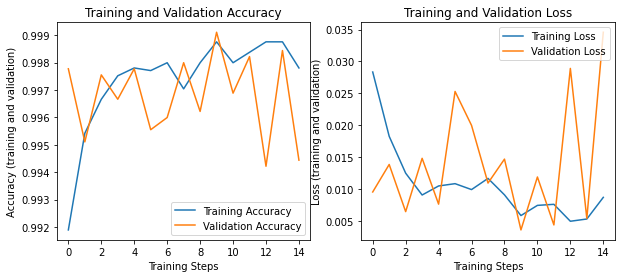

In [10]:
import matplotlib.pylab as plt
import numpy as np
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

class: Malignant, confidence: 1.000000


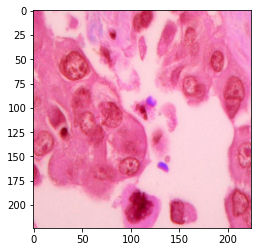

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 1.000000


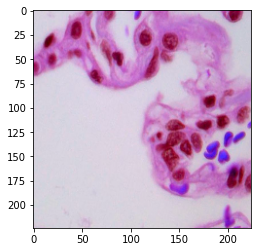

class: Malignant, confidence: 1.000000


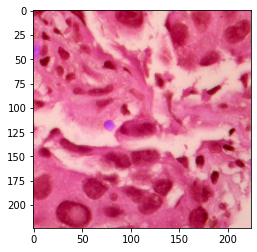

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 1.000000


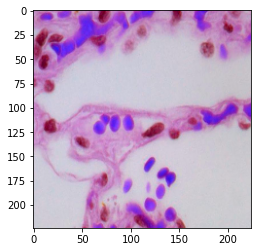

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.987946


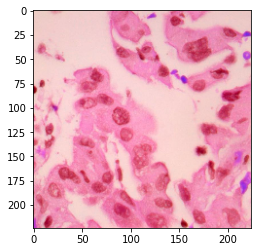

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 1.000000


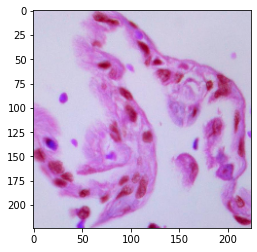

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.999997


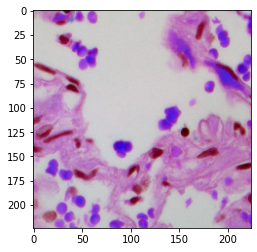

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 1.000000


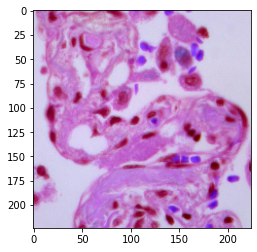

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 1.000000


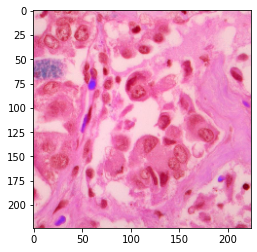

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 1.000000


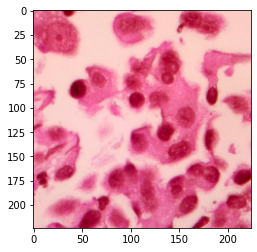

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 1.000000


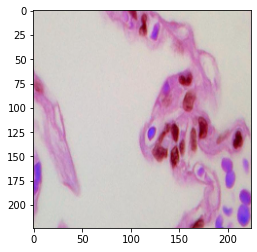

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 0.915917


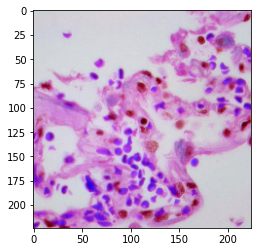

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 1.000000


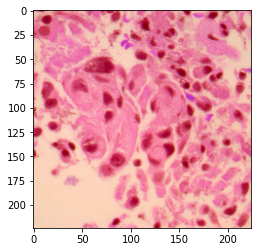

<Figure size 432x288 with 0 Axes>

class: Benign, confidence: 0.988662


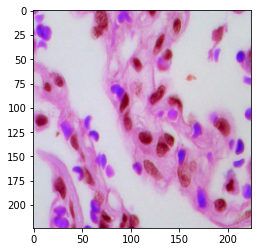

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 1.000000


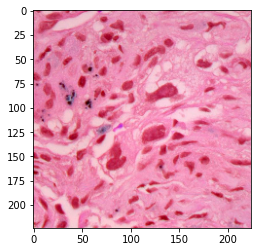

<Figure size 432x288 with 0 Axes>

class: Malignant, confidence: 1.000000


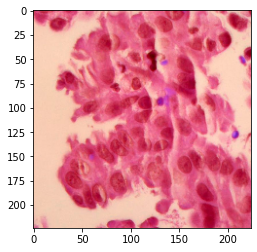

<Figure size 432x288 with 0 Axes>

In [11]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    return img
def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    return {Labels[classx]: x[classx]}
images = random.sample(validation_generator.filenames, 16)
for idx, filename in enumerate(images):
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [15]:
import time
t = time.time()
export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.models.save_model(model, export_path)
export_path

INFO:tensorflow:Assets written to: /tmp/saved_models/1655410758/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1655410758/assets


'/tmp/saved_models/1655410758'

In [16]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.models.load_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    return {Labels[class_idx]: probabilities[class_idx]}

SOURCE: class: malignant, file: malignant/lungaca1602.jpeg
PREDICTED: class: Malignant, confidence: 1.000000


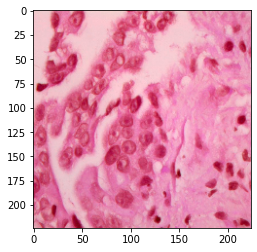

<Figure size 432x288 with 0 Axes>

SOURCE: class: malignant, file: malignant/lungaca2603.jpeg
PREDICTED: class: Malignant, confidence: 1.000000


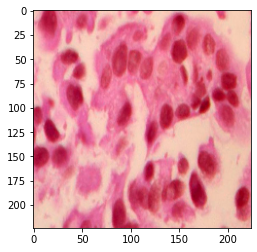

In [17]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    img = upload(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [18]:
!mkdir "tflite_model"
TFLITE_MODEL = "tflite_model/model2.tflite"
# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))
# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)
# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

11553468